# ⚽S4E1 - EDA & initial submission - Binary Classification with a Bank Churn Dataset 

Welcome to 2024! For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

## Evaluation

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Submission Format

For each id in the test set, you must predict the probability for the target variable Exited. The file should contain a header and have the following format:

```
id,Exited
0,0.9
1,0.1
2,0.5
etc.
```

## Data Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. 

# Code

## ToC

- [Imports](#Imports)


## Imports

/home/wiktor/.pyenv/versions/3.11.3/envs/kaggling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


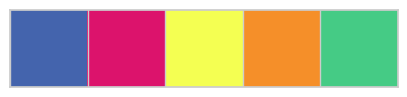

In [1]:
# essentials
import os
import pathlib
from copy import copy


import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, TweedieRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer, roc_curve

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

# others
import xgboost as xgb 
import lightgbm as lgb

import optuna
import shap

RANDOM_SEED = 64

palette = ["#4464ad", "#dc136c", "#F4FF52", "#f58f29","#45cb85"]

sns.set_theme(style="whitegrid")
sns.set_palette(palette)
sns.palplot(palette)

## Data loading & EDA

First we will check

1. Number and types of columns
2. Number of rows in train and test
2. Missing values
3. Target variable distribution

In [2]:
IN_KAGGLE = False

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
input_folder = kaggle_folder if IN_KAGGLE else local_folder
train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")

target_col = "Exited"

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    return df

train_df = initial_feature_engineering(train_df)

train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,True,False,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,True,True,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,True,False,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,True,True,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,True,True,15068.83,0


In [3]:
num_columns = len(train_df.columns)
num_rows = len(train_df)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  bool   
 10  IsActiveMember   165034 non-null  bool   
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: bool(2), float64(3), int64(5), object(3)
memory usage: 15.4+ MB


<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>Data shape</h4>
        <p>Data contains 13 columns, of which 8 are numeric, 2 are boolean and 3 are categorical. There are no missing values.</p>
    </div>
</div>

### Comparison of target column value counts across train and original datasets

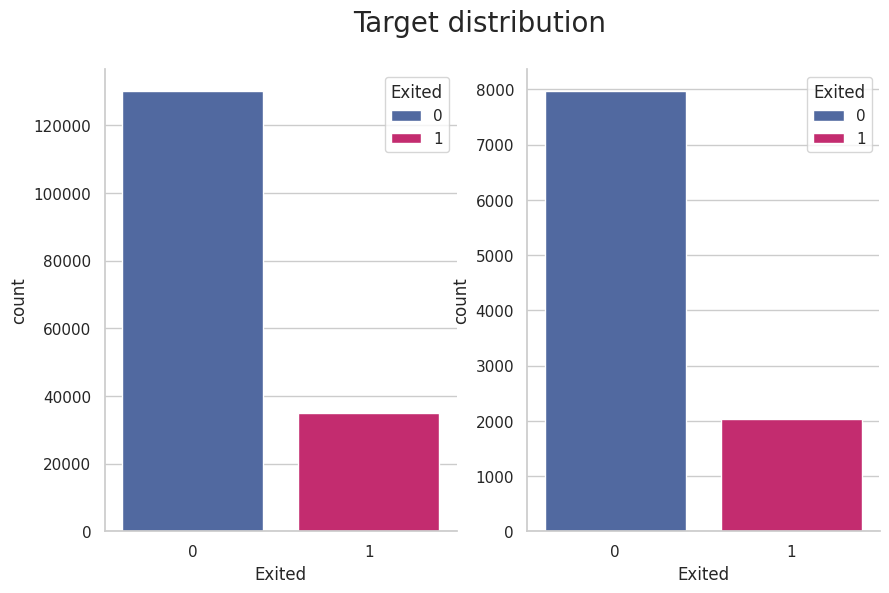

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.despine()

fig.suptitle("Target distribution", fontsize=20)

sns.countplot(x=target_col, data=train_df, hue=target_col, ax=ax[0])
sns.countplot(x=target_col, data=original_df, hue=target_col, ax=ax[1])

plt.show()

The palette list has more values (5) than needed (2), which may not be intended.
The palette list has more values (5) than needed (2), which may not be intended.


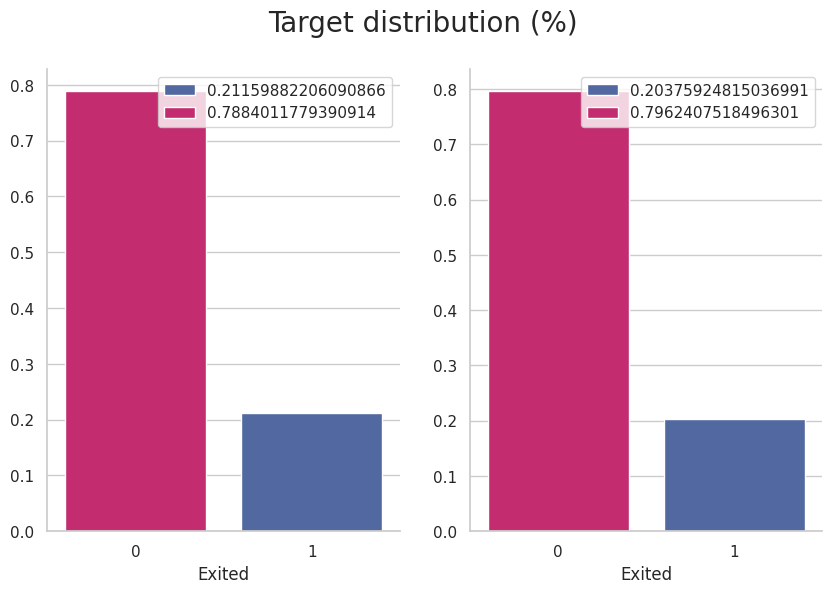

In [5]:

total_train = len(train_df)
total_original = len(original_df)


train_target_pct = train_df[target_col].value_counts() / total_train
original_target_pct = original_df[target_col].value_counts() / total_original


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.despine()

fig.suptitle("Target distribution (%)", fontsize=20)

sns.barplot(x=train_target_pct.index, y=train_target_pct.values, ax=ax[0], hue=train_target_pct.values, palette=palette)
sns.barplot(x=original_target_pct.index, y=original_target_pct.values, ax=ax[1], hue=original_target_pct.values, palette=palette)
plt.show()

In [6]:
train_df[target_col].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

The competition dataset and original have similar target distribution - around 80% of customers stay with the bank in each.


Next steps:

4. Distribution of numeric features
5. Distribution of categorical features
6. Correlation between numeric features and target
7. Chi-square test on categorical features and target

## Distribution of numeric features

In [7]:
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
# remove target col from list
numeric_features.remove(target_col)
print(numeric_features)

['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


#### CustomerId - 'unique' identifier?

In [8]:
train_df['CustomerId'].value_counts()

CustomerId
15682355    121
15570194     99
15585835     98
15595588     91
15648067     90
           ... 
15635203      1
15806982      1
15691104      1
15624936      1
15815050      1
Name: count, Length: 23221, dtype: int64

In [9]:
val_cnt = train_df['CustomerId'].value_counts().reset_index()
val_cnt[ val_cnt['count'] > 1 ]

,CustomerId,count
0,15682355,121
1,15570194,99
2,15585835,98
3,15595588,91
4,15648067,90
...,...,...
13915,15583738,2
13916,15605734,2
13917,15606465,2
13918,15806836,2


#### CreditScore


<Axes: xlabel='CreditScore', ylabel='Count'>

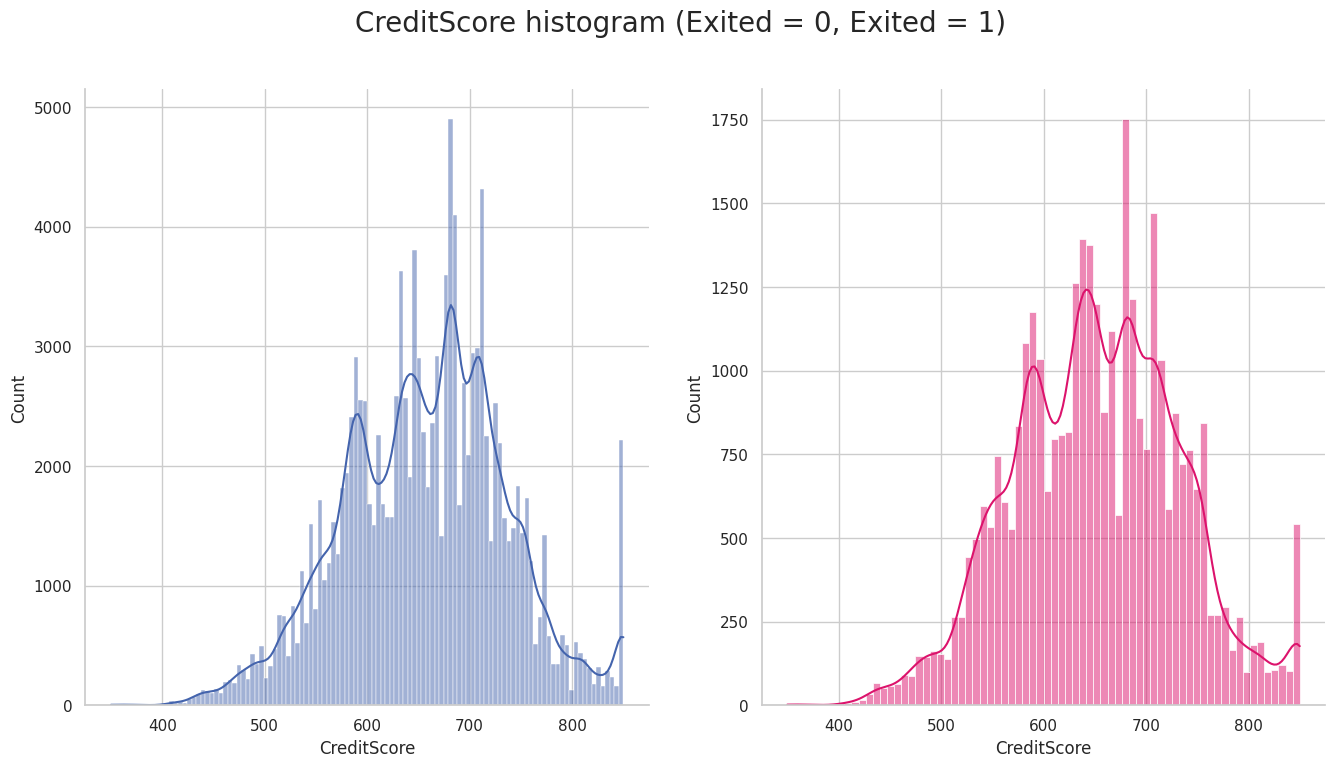

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()

fig.suptitle(f"CreditScore histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="CreditScore", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="CreditScore", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>Credit score</h4>
        <p>
          <ul>
            <li>Distribution has slight left skew, and we see the 850 cutoff as it's the max FICO credit score.</li>
            <li>Min value is 350, max is 850, 50% of customers have score of at least 659. FICO scores could be as low as 300, but we don't have such customers in the dataset.</li>
            <li>Credit score is not very different between customers who stay and leave</li>
          </ul>        
        </p>
    </div>
</div>

#### Age

In [11]:
train_df['Age'].describe()

count    165034.000000
mean         38.125888
std           8.867205
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

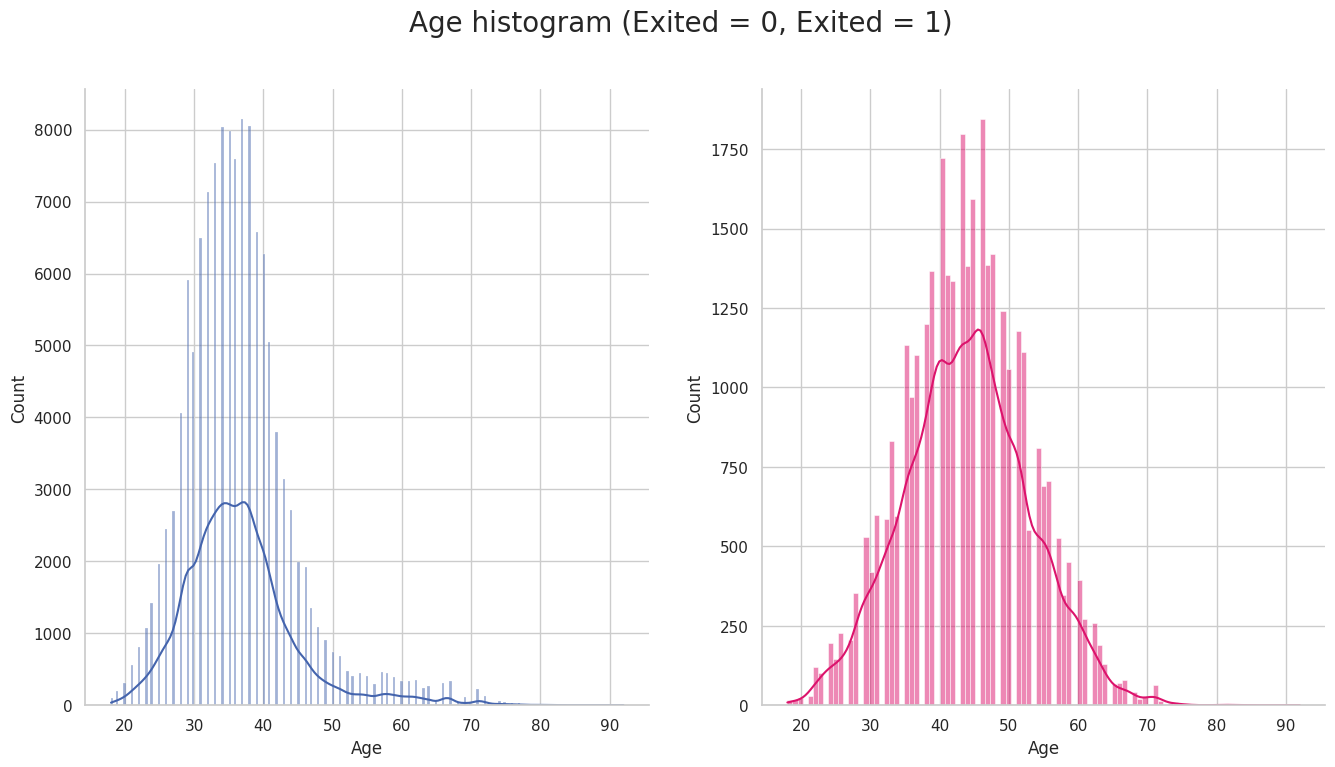

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Age histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="Age", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="Age", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

Min Age is 18 while the oldest customer is 92 years old.

#### Tenure

In [13]:
train_df['Tenure'].describe()

count    165034.000000
mean          5.020353
std           2.806159
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          10.000000
Name: Tenure, dtype: float64

In [14]:
train_df['Tenure'].value_counts()

Tenure
2     18045
7     17810
4     17554
8     17520
5     17268
1     16760
9     16709
3     16630
6     15822
10     5909
0      5007
Name: count, dtype: int64

In [15]:
customers_less_than_1_yr = train_df[train_df['Tenure'] < 1]['CustomerId'].unique()
customers_more_than_9_yrs = train_df[train_df['Tenure'] > 9]['CustomerId'].unique()
total_cust = len(train_df)
print(f"Customers with less than 1 year of tenure: {len(customers_less_than_1_yr)/total_cust*100:.2f}%")
print(f"Customers with more than 9 years of tenure: {len(customers_more_than_9_yrs)/total_cust*100:.2f}%")

Customers with less than 1 year of tenure: 2.14%
Customers with more than 9 years of tenure: 2.49%


<Axes: xlabel='Tenure', ylabel='Count'>

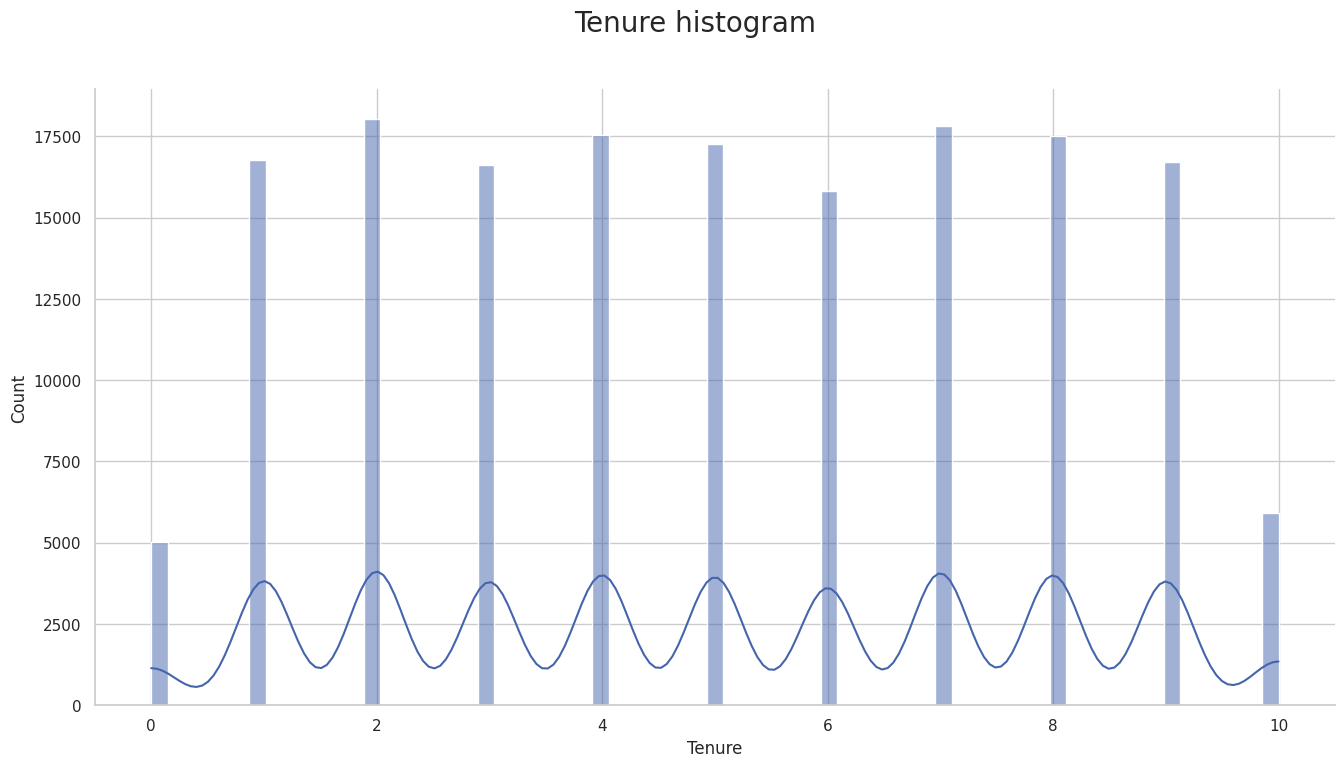

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Tenure histogram", fontsize=20)

sns.histplot(x="Tenure", data=train_df, ax=ax, kde=True, color=palette[0])

<Axes: xlabel='Tenure', ylabel='Count'>

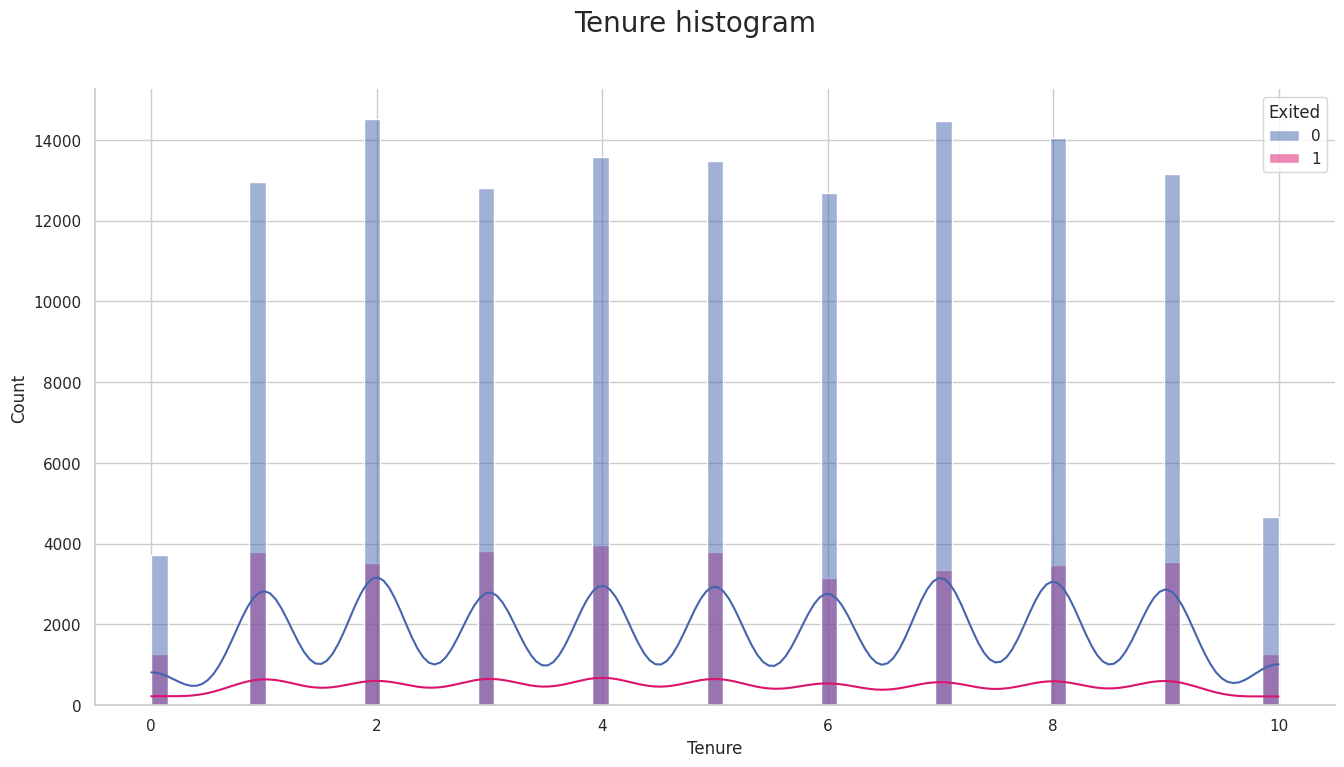

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Tenure histogram", fontsize=20)

sns.histplot(x="Tenure", data=train_df, ax=ax, kde=True, hue=target_col, color=palette[0])

Around 2% of customers have been with the bank for more than 9 years. Around the same number of customers came to bank less than 1 year ago.

#### Balance

In [18]:
train_df['Balance'].describe()

count    165034.000000
mean      55478.086689
std       62817.663278
min           0.000000
25%           0.000000
50%           0.000000
75%      119939.517500
max      250898.090000
Name: Balance, dtype: float64

In [19]:
train_df[train_df[target_col] == 0]['Balance'].describe()

count    130113.000000
mean      51255.807752
std       62189.978970
min           0.000000
25%           0.000000
50%           0.000000
75%      116858.660000
max      250898.090000
Name: Balance, dtype: float64

In [20]:
train_df[train_df[target_col] == 1]['Balance'].describe()

count     34921.000000
mean      71209.978085
std       62646.691947
min           0.000000
25%           0.000000
50%       98955.870000
75%      125437.140000
max      238387.560000
Name: Balance, dtype: float64

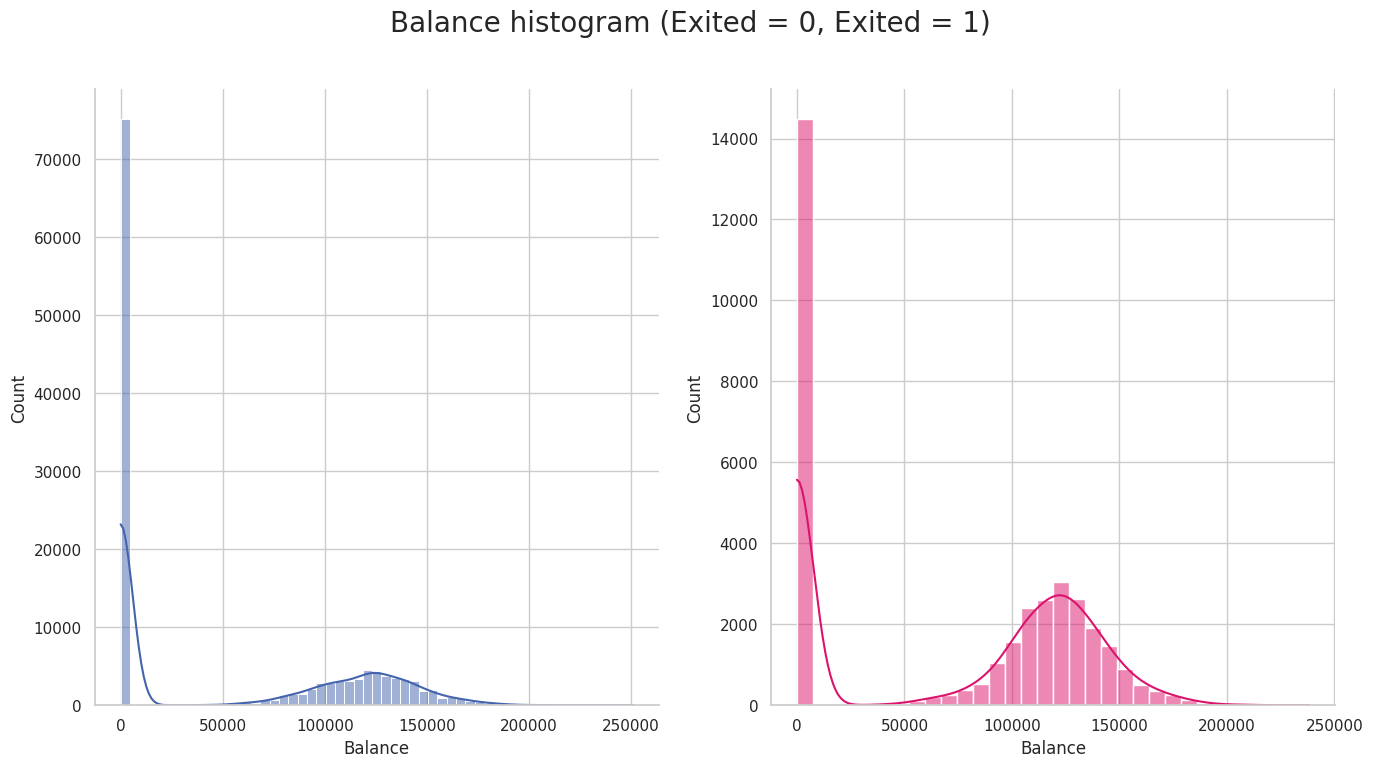

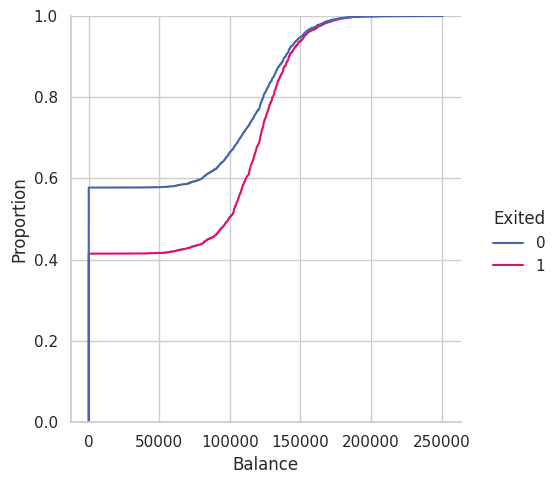

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Balance histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)
# distribution plot 

sns.histplot(x="Balance", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="Balance", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

sns.displot(train_df, x="Balance", hue=target_col, kind="ecdf")

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>Balance</h4>
        <p>
          <ul>
            <li>More than 50% of customers balance was 0 (at the time of data collection). Max balance is around 250k.</li>
            <li>Among customers who exited the bank, 50% of them had a balance of at least ~100k</li>
          </ul>        
        </p>
    </div>
</div>

#### NumOfProducts

In [22]:
train_df['NumOfProducts'].describe()

count    165034.000000
mean          1.554455
std           0.547154
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           4.000000
Name: NumOfProducts, dtype: float64

In [23]:
train_df[train_df[target_col] == 0]['NumOfProducts'].describe()

count    130113.000000
mean          1.615273
std           0.494632
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           4.000000
Name: NumOfProducts, dtype: float64

In [24]:
train_df[train_df[target_col] == 0]['NumOfProducts'].describe()

count    130113.000000
mean          1.615273
std           0.494632
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           4.000000
Name: NumOfProducts, dtype: float64

<Axes: xlabel='NumOfProducts', ylabel='Count'>

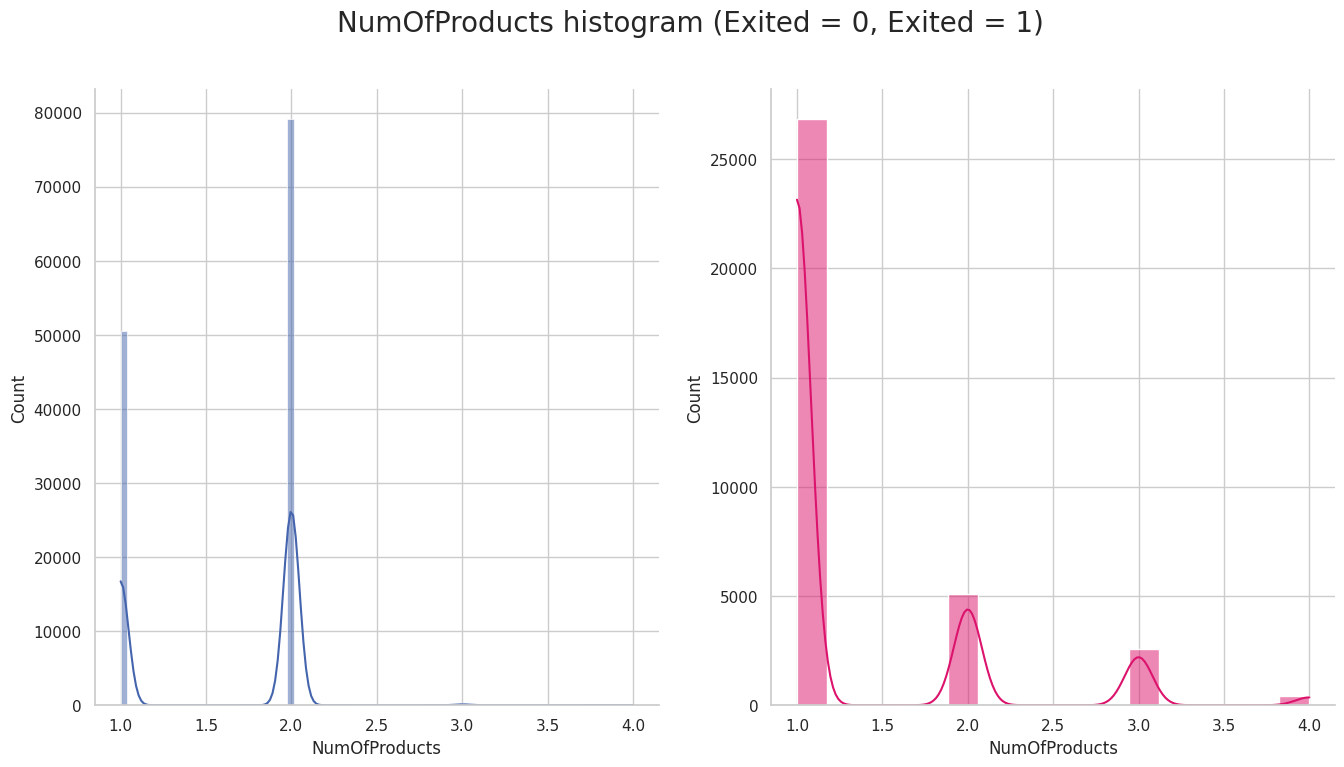

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"NumOfProducts histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="NumOfProducts", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="NumOfProducts", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

<Axes: xlabel='NumOfProducts', ylabel='Count'>

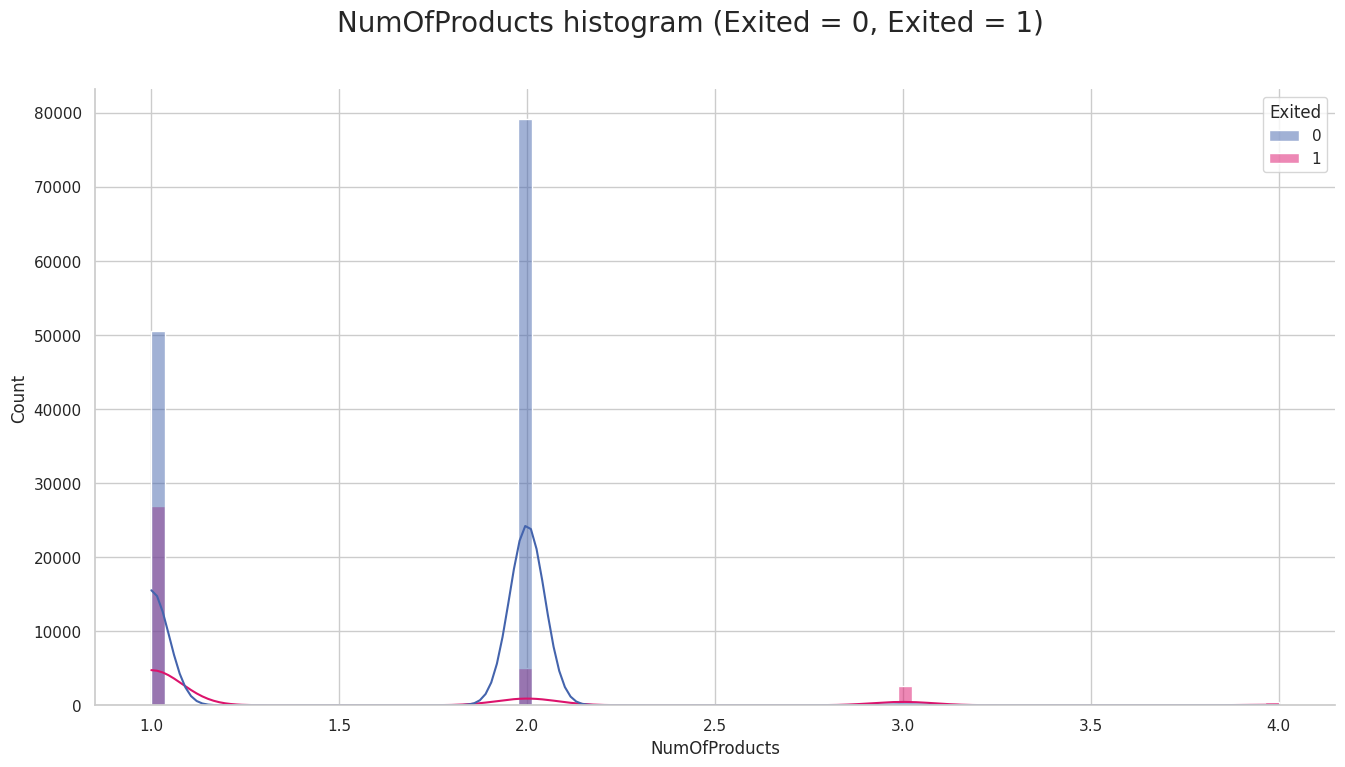

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"NumOfProducts histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="NumOfProducts", data=train_df, ax=ax, kde=True, hue=target_col, color=palette[0])

In [27]:
three_or_more_products = train_df[train_df['NumOfProducts'] >= 3]
total_num_three_or_more_products = len(three_or_more_products)
val_cnt = three_or_more_products[target_col].value_counts()
# calculate pct
val_cnt = val_cnt / total_num_three_or_more_products * 100
val_cnt

Exited
1    88.156723
0    11.843277
Name: count, dtype: float64

In [28]:
less_than_three = train_df[train_df['NumOfProducts'] < 3]
less_than_three[target_col].value_counts()

Exited
0    129714
1     31951
Name: count, dtype: int64

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>NumOfProducts</h4>
        <p>
          <ul>
            <li>In both groups, min number of products was 1 while max was 4</li>
            <li>Among customers who stay with bank, most of them have 2 products, while having 1 product is the second most common</li>
            <li>Among customers who exited the bank, having 1 product is the most common, but having 3 or 4 products is much more common than in the other group</li>
            <li>Almost 90% of customers who have 3 or 4 products leave the bank</li>
          </ul>        
        </p>
    </div>
</div>

#### EstimatedSalary

In [29]:
train_df["EstimatedSalary"].describe()

count    165034.000000
mean     112574.822734
std       50292.865585
min          11.580000
25%       74637.570000
50%      117948.000000
75%      155152.467500
max      199992.480000
Name: EstimatedSalary, dtype: float64

In [30]:
train_df[train_df[target_col] == 0]["EstimatedSalary"].describe()

count    130113.000000
mean     112084.293725
std       50214.655044
min          11.580000
25%       74425.410000
50%      116977.890000
75%      153727.320000
max      199992.480000
Name: EstimatedSalary, dtype: float64

In [31]:
train_df[train_df[target_col] == 1]["EstimatedSalary"].describe()

count     34921.000000
mean     114402.496656
std       50542.030878
min          11.580000
25%       74965.440000
50%      120892.960000
75%      158750.530000
max      199992.480000
Name: EstimatedSalary, dtype: float64

<Axes: xlabel='EstimatedSalary', ylabel='Count'>

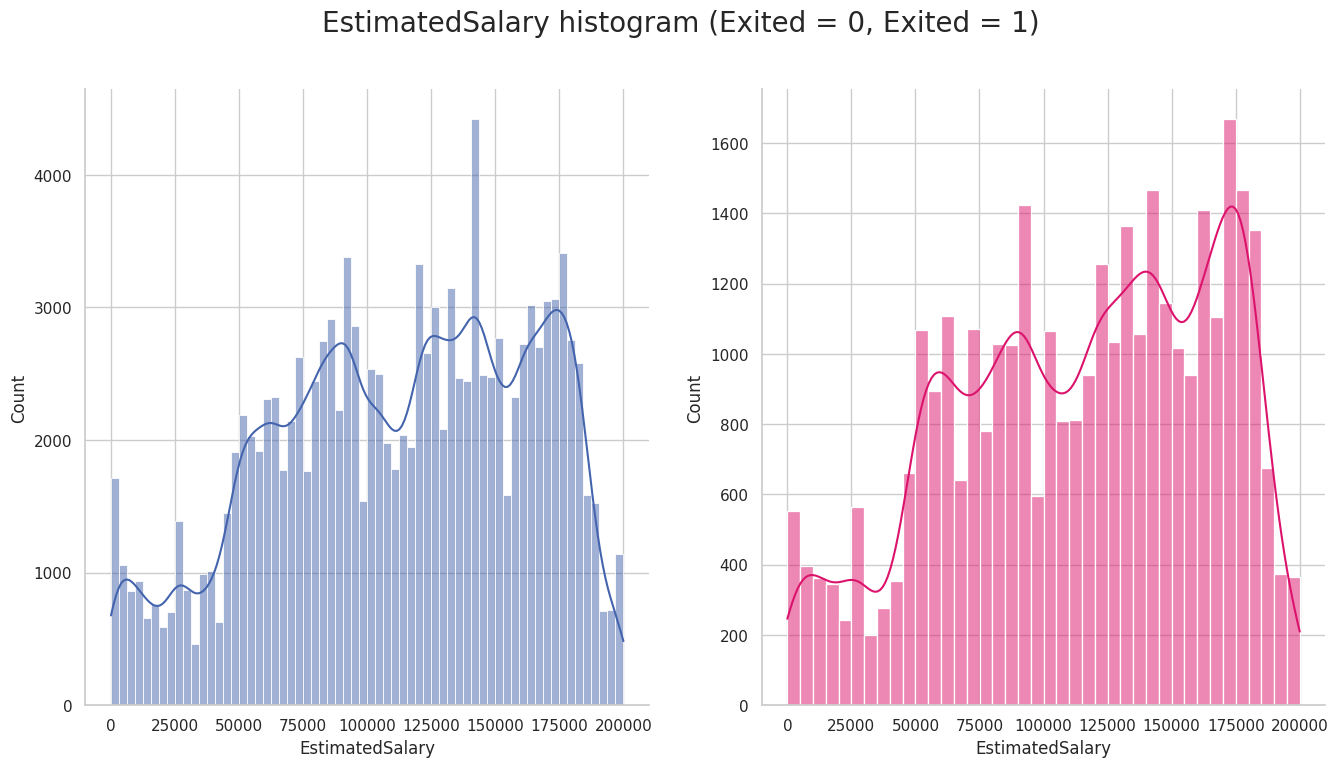

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"EstimatedSalary histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="EstimatedSalary", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="EstimatedSalary", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()



People who leave the bank have a slightly higher salary than those who stay.

## Categorical features

In [33]:
categorical_features = train_df.select_dtypes(exclude=np.number).columns.tolist()

print(categorical_features)

['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']


#### HasCrCard

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


,Exited,HasCrCard,proportion
0,0,True,0.598313
1,0,False,0.190088
2,1,True,0.155641
3,1,False,0.055958


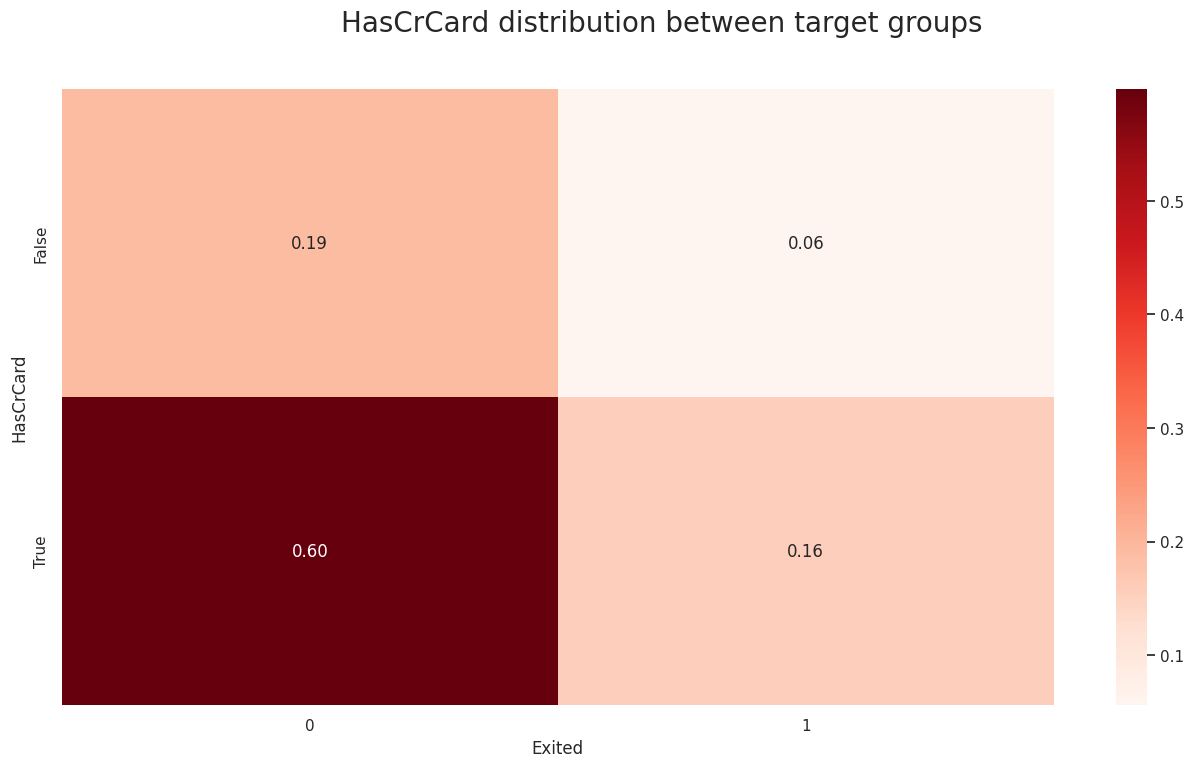

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"HasCrCard distribution between target groups", fontsize=20)

val_cnt = train_df[[target_col, 'HasCrCard']].value_counts(normalize=True).reset_index()
pivot_table = val_cnt.pivot_table(index='HasCrCard', columns=target_col, values='proportion', aggfunc=sum, fill_value=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


,Exited,HasCrCard,count
0,0,True,98742
1,0,False,31371
2,1,True,25686
3,1,False,9235


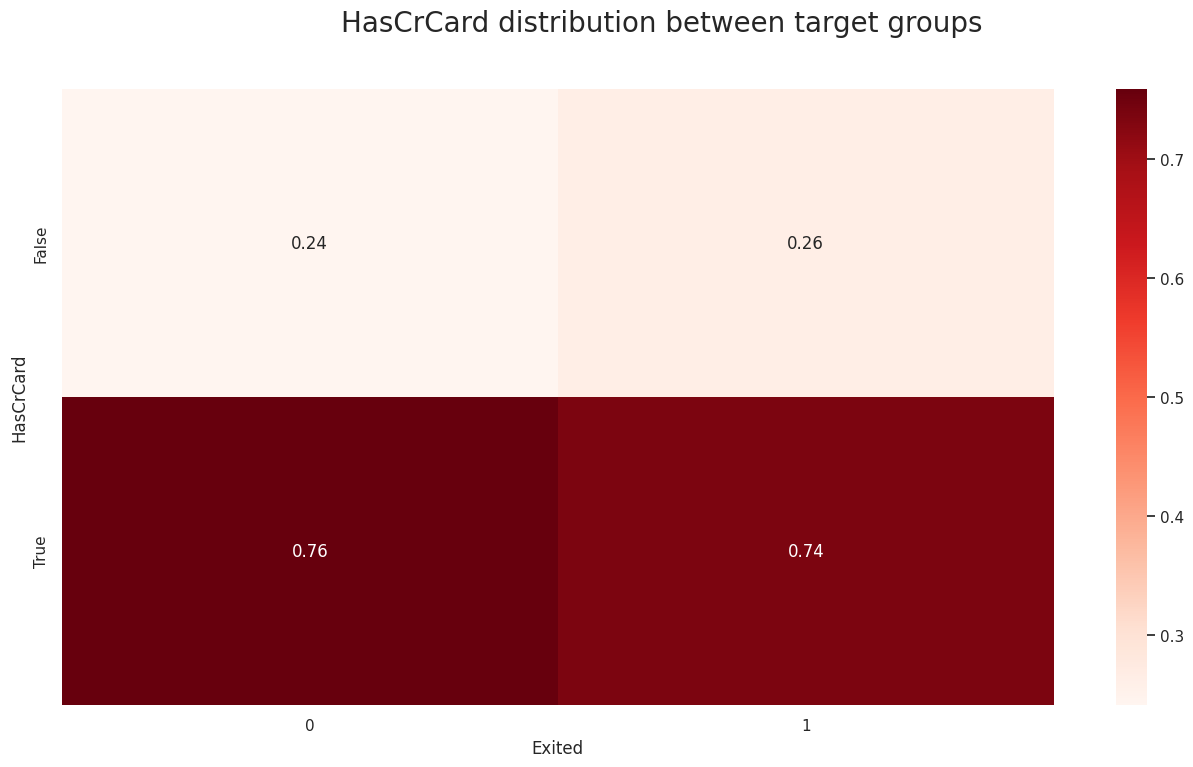

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"HasCrCard distribution between target groups", fontsize=20)

val_cnt = train_df[[target_col, 'HasCrCard']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='HasCrCard', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

#### IsActiveMember

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


,Exited,IsActiveMember,proportion
0,0,True,0.435377
1,0,False,0.353024
2,1,False,0.149206
3,1,True,0.062393


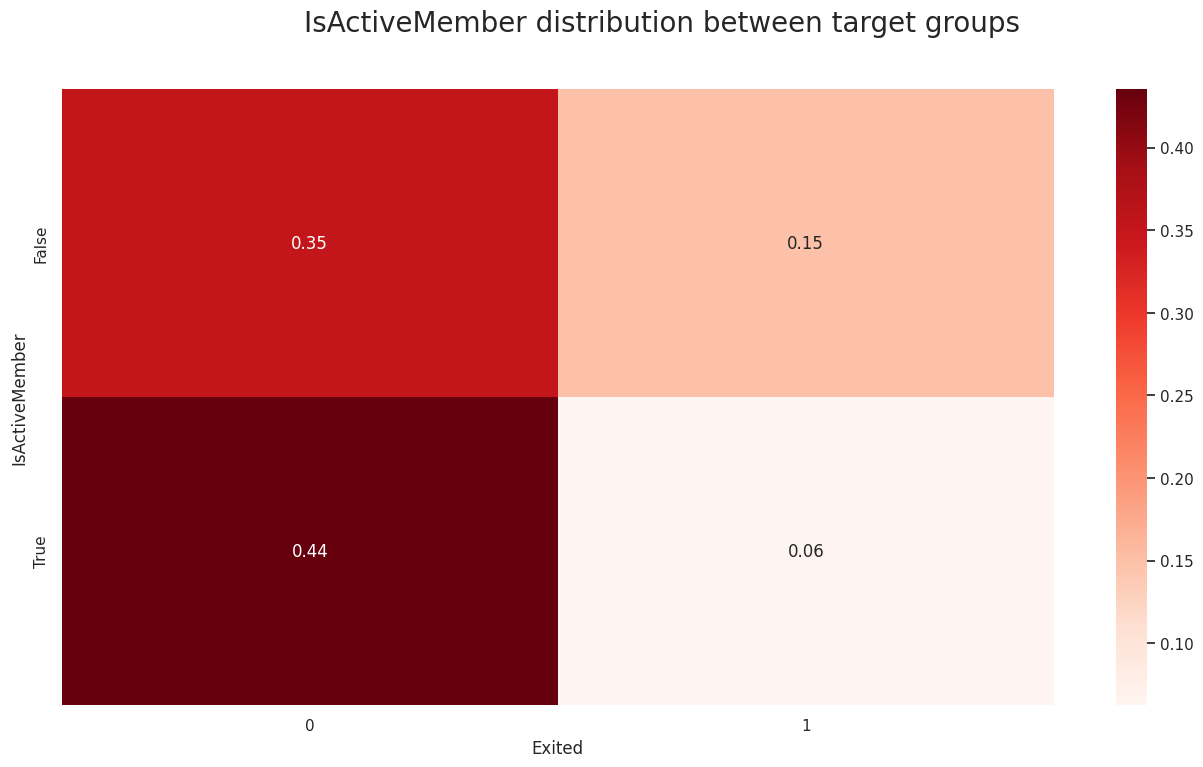

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"IsActiveMember distribution between target groups", fontsize=20)

val_cnt = train_df[[target_col, 'IsActiveMember']].value_counts(normalize=True).reset_index()
pivot_table = val_cnt.pivot_table(index='IsActiveMember', columns=target_col, values='proportion', aggfunc=sum, fill_value=0)

sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


,Exited,IsActiveMember,count
0,0,True,71852
1,0,False,58261
2,1,False,24624
3,1,True,10297


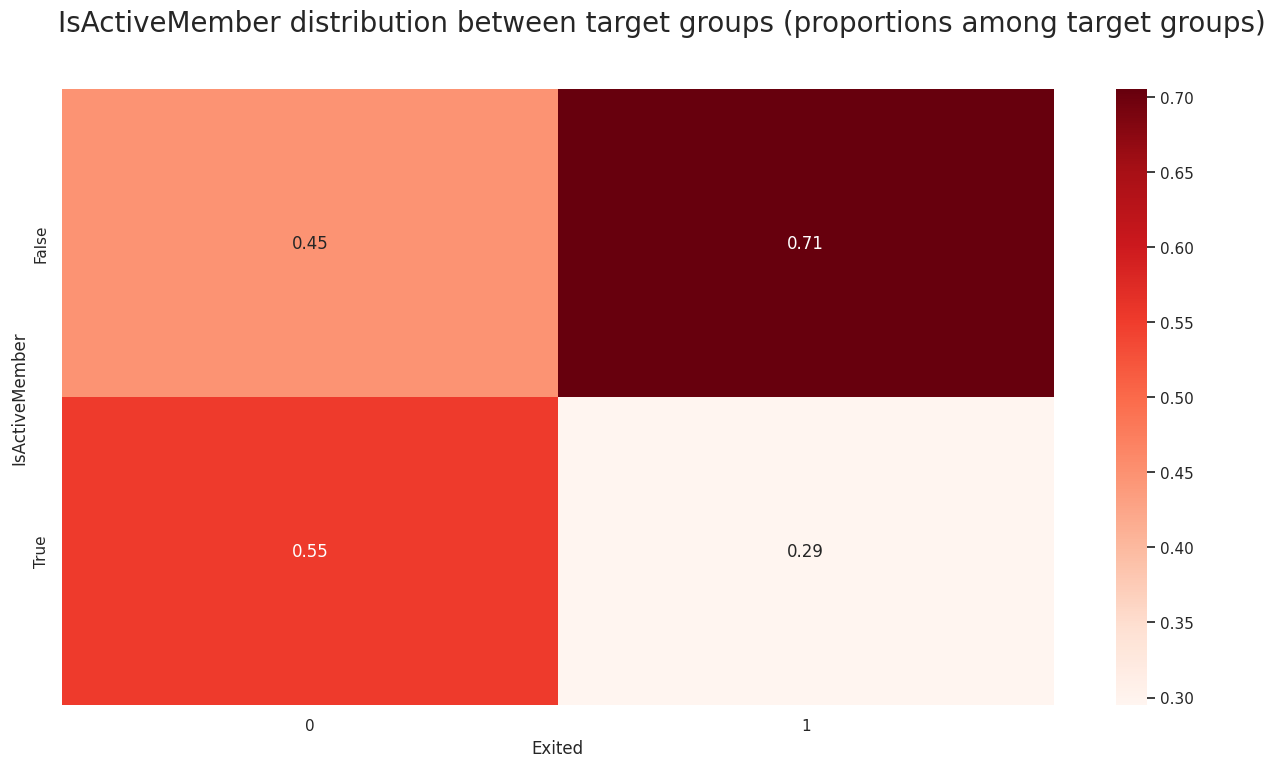

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"IsActiveMember distribution between target groups (proportions among target groups)", fontsize=20)

val_cnt = train_df[[target_col, 'IsActiveMember']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='IsActiveMember', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>HasCrCard & IsActiveMember</h4>
        <p>
          <ul>
            <li>Having a credit card does not seem to contribute to staying or leaving.</li>
            <li>70% of people who left were not active members while only 55% of people who stayed were active members.</li>
          </ul>        
        </p>
    </div>
</div>

#### Gender

In [38]:
train_df[[target_col, 'Gender']].value_counts()

Exited  Gender
0       Male      78334
        Female    51779
1       Female    20105
        Male      14816
Name: count, dtype: int64

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


,Exited,Gender,count
0,0,Male,78334
1,0,Female,51779
2,1,Female,20105
3,1,Male,14816


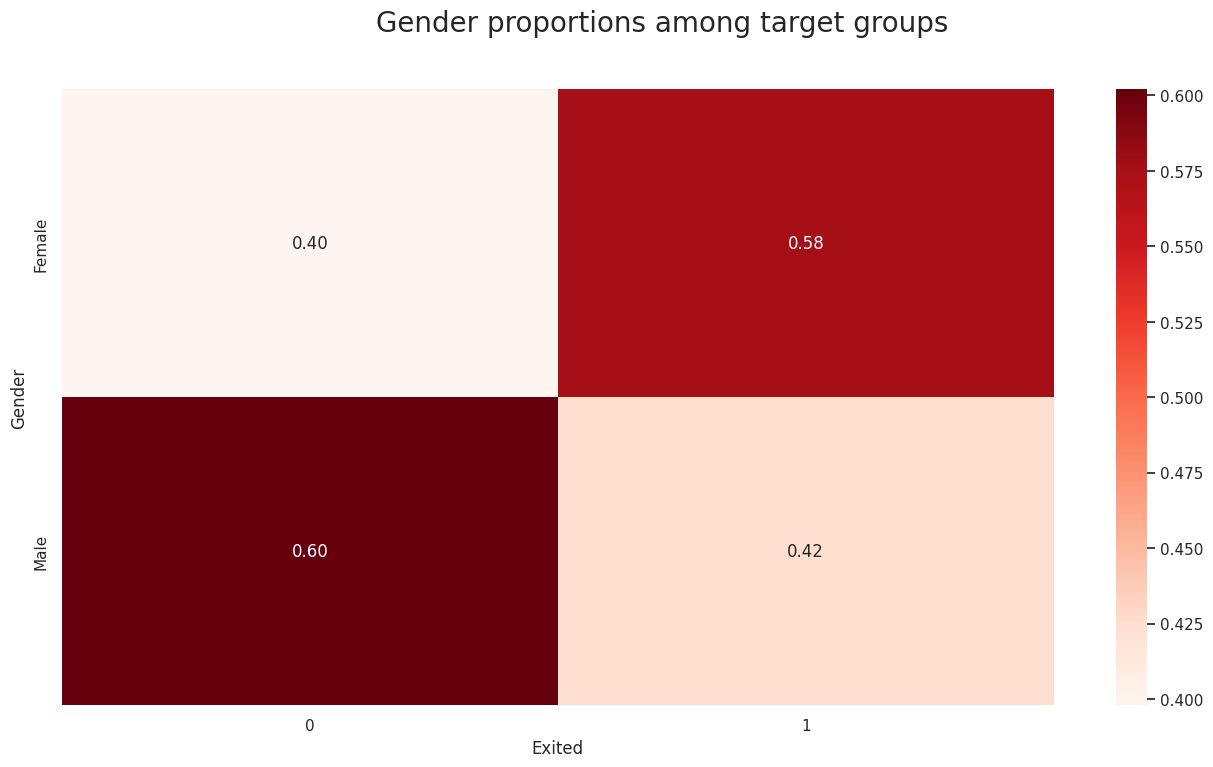

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Gender proportions among target groups", fontsize=20)

val_cnt = train_df[[target_col, 'Gender']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='Gender', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

Among people who stay with bank, 60% are men, while 60% of people who leave the bank are women.

#### Geography

In [40]:
train_df['Geography'].value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


,Exited,Geography,count
0,0,France,78643
1,0,Spain,29978
2,0,Germany,21492
3,1,France,15572
4,1,Germany,13114
5,1,Spain,6235


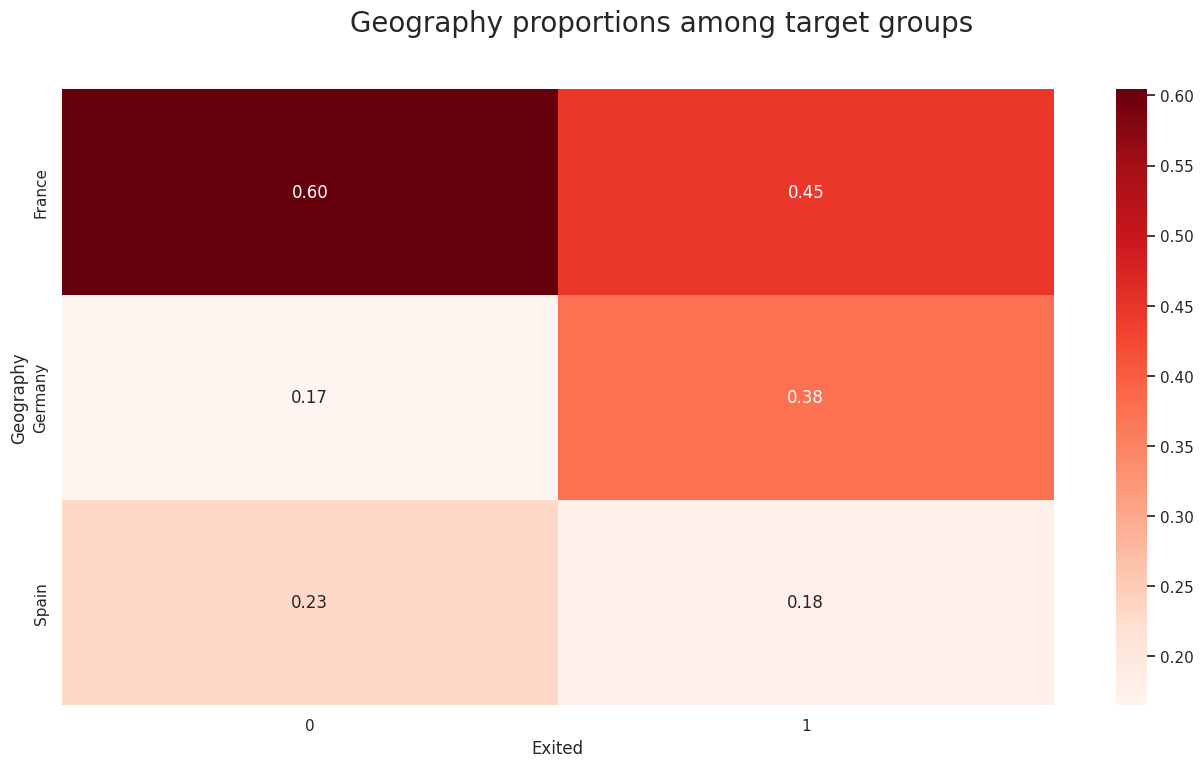

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Geography proportions among target groups", fontsize=20)

val_cnt = train_df[[target_col, 'Geography']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='Geography', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

#### Surname

In [42]:
train_df['Surname'].value_counts()

Surname
Hsia         2456
T'ien        2282
Hs?          1611
Kao          1577
Maclean      1577
             ... 
Samaniego       1
Lawley          1
Bonwick         1
Tennant         1
Elkins          1
Name: count, Length: 2797, dtype: int64

Not likely to be useful for prediction. We will drop this column before training.

## Correlation between numeric features and target

<Axes: >

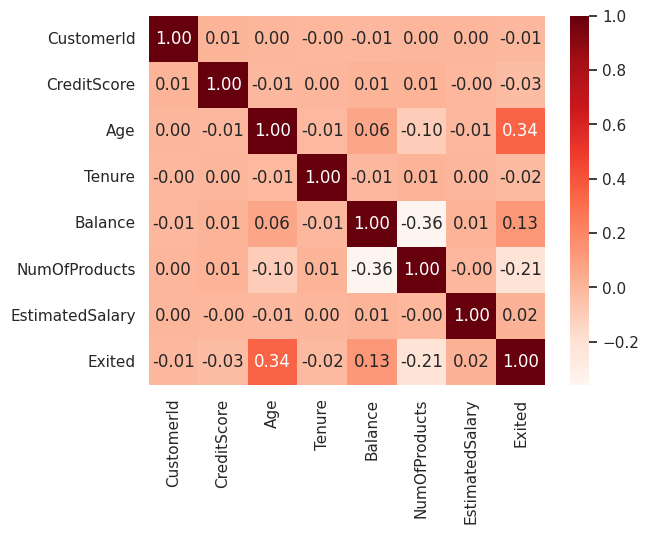

In [43]:
# plot correlation matrix

corr_matrix = train_df[numeric_features + [target_col]].corr( method='pearson')


fig.suptitle("Correlation matrix", fontsize=20)

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Reds")

There are not corellated features

## Chi-square test on categorical features and target

Here we want to create a table which could tell us by which features the target groups differ the most. We will use chi-square test to check if the difference is statistically significant.

In [44]:
from scipy.stats import chi2_contingency

def chi_square_test(dataframe, target_col, categorical_features):
    # Create a dictionary to hold the results
    results = {"Feature": [], "Chi-Square Statistic": [], "p-Value": [], "Significant": []}

    # Split the data into two groups based on the target column
    group_1 = dataframe[dataframe[target_col] == 0]
    group_2 = dataframe[dataframe[target_col] == 1]

    # Iterate over each categorical feature
    for feature in categorical_features:
        # Create a contingency table
        contingency_table = pd.crosstab(dataframe[feature], dataframe[target_col])

        # Perform the chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Determine if the result is significant
        significant = p < 0.005

        # Append the results to the dictionary
        results["Feature"].append(feature)
        results["Chi-Square Statistic"].append(chi2)
        results["p-Value"].append(p)
        results["Significant"].append(significant)

    # Convert the dictionary to a DataFrame and return it
    return pd.DataFrame(results).sort_values(by="Chi-Square Statistic", ascending=False)

In [45]:
results_df = chi_square_test(train_df, target_col, ["Geography", "IsActiveMember", "Gender", "HasCrCard"])
results_df

,Feature,Chi-Square Statistic,p-Value,Significant
0,Geography,7358.673765,0.000000e+00,True
1,IsActiveMember,7293.408511,0.000000e+00,True
2,Gender,3538.452550,0.000000e+00,True
3,HasCrCard,80.780230,2.522693e-19,True


This did not prove to uncover anything interesting 

## Model training

In [46]:
train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    train_df = train_df.drop(columns=f)

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    df['Gender'] = df['Gender'].map({ "Male": 0, "Female": 1}).astype("bool")
    # encode geography
    df = pd.get_dummies(df, columns=['Geography'])

    return df


train_df = initial_feature_engineering(train_df)

X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=target_col), train_df[target_col], test_size=0.2, random_state=RANDOM_SEED, stratify=train_df[target_col])

In [47]:

def create_pipeline(model, numeric_scalers=("scaler", StandardScaler())):
    numeric_pipeline = Pipeline(
        [numeric_scalers]
    )

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_features),
        #("categorical", categorical_pipeline, categorical_features),
    ], remainder='passthrough')

    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model),
    ])

def train_models(models, X_train, y_train):
    trained_models = {}
    for model_name, model in tqdm(models.items()):
        model = create_pipeline(model)
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

def evaluate_models(models, X_val, y_val):
    # create a dataframe with "model_name", "accuracy", "precision", "recall", "area under the ROC curve"
    results_df = pd.DataFrame(columns=["model_name", "accuracy", "precision", "recall", "auc"])

    for model_name, model in tqdm(models.items()):
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                "model_name": [model_name],
                "accuracy": [model.score(X_val, y_val)],
                "precision": [sklearn.metrics.precision_score(y_val, y_pred)],
                "recall": [sklearn.metrics.recall_score(y_val, y_pred)],
                "auc": [sklearn.metrics.roc_auc_score(y_val, y_proba)],
            })
        ])
    return results_df

def plot_roc_curve(models, X_val, y_val):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    palette_to_use = sns.color_palette("husl", len(models))
    # for each model, plot the roc curve in the same plot, with other color
    for i, (model_name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color=palette_to_use[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    # show legend
    ax.legend()


In [50]:
models = {
    "xgboost": xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1, device="gpu"),
    "lightgbm": lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1, device="gpu"),
    "logistic_regression": LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    "knn": KNeighborsClassifier(n_jobs=-1),
    "random_forest": RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "extra_trees": ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "bagging": BaggingClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "sgd": SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1),
}

print("Training models...")
trained_models = train_models(models, X_train, y_train)
print("Evaluating models...")
results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

Training models...


 12%|█▎        | 1/8 [00:01<00:07,  1.13s/it]


LightGBMError: No OpenCL device found

Comparison of ROC curves for trained models:

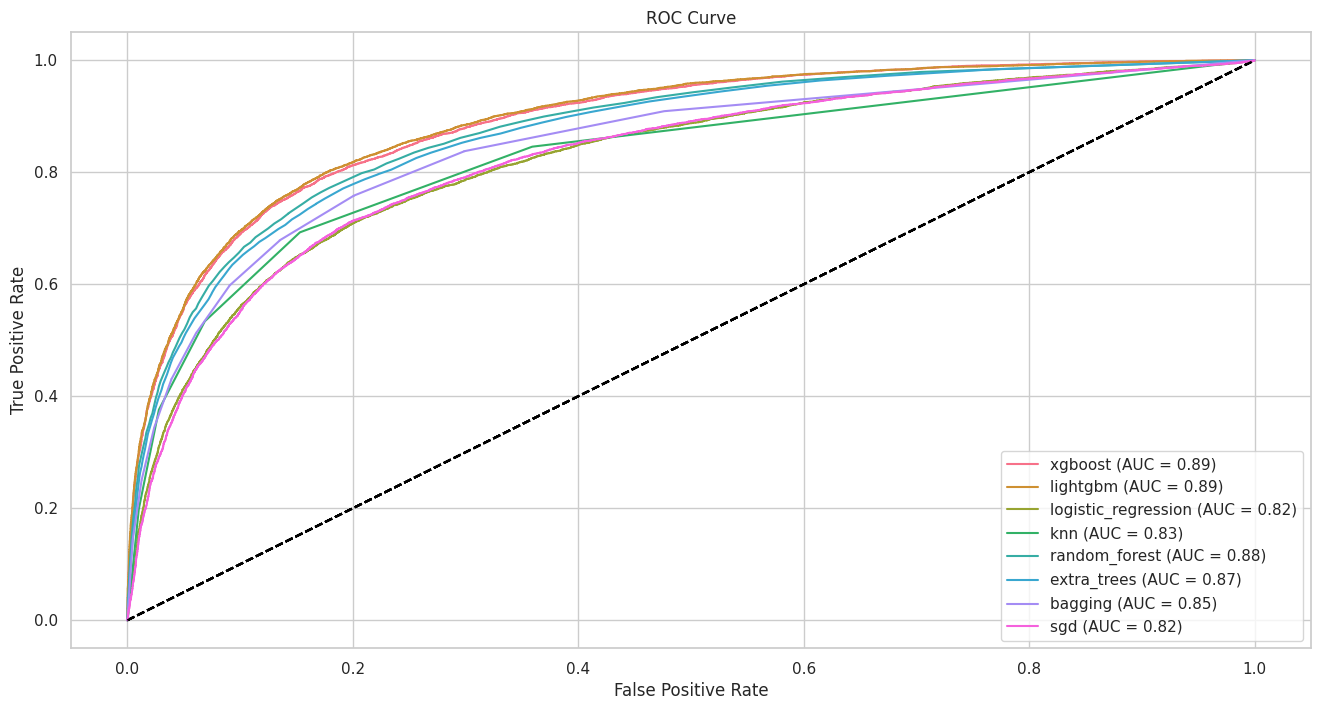

In [ ]:
plot_roc_curve(trained_models, X_val, y_val)

## Optimizing hyperparameters for the best model

We will use optuna here to first optimize all different hyperparameters

In [ ]:
len(X_train) * 0.05

6601.35

In [ ]:
number_of_samples = int(len(X_train) * 0.05)
hyperparameter_indices = X_train.sample(number_of_samples, random_state=RANDOM_SEED).index

X_train_hyperparameter = X_train.loc[hyperparameter_indices]
y_train_hyperparameter = y_train.loc[hyperparameter_indices]

def objective_lightgbm(trial):
    lightgbm_model_optuna = lgb.LGBMClassifier(random_state=RANDOM_SEED, verbose=-1, n_jobs=-1, device="gpu")
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    clf = create_pipeline(lightgbm_model_optuna)
    params = {
        'classifier__n_estimators' : trial.suggest_int('classifier__n_estimators', 50, 1000),
        "classifier__learning_rate" : trial.suggest_float('classifier__learning_rate',1e-4, 0.1),
        "classifier__max_depth":trial.suggest_int('classifier__max_depth',3,50),
        'classifier__reg_alpha': trial.suggest_float('classifier__reg_alpha', 1e-3, 10.0),
        'classifier__reg_lambda': trial.suggest_float('classifier__reg_lambda', 1e-3, 10.0),
        "classifier__min_child_weight" : trial.suggest_float('classifier__min_child_weight', 0.5,4),
        "classifier__min_child_samples" : trial.suggest_int('classifier__min_child_samples',1,100),
        "classifier__subsample" : trial.suggest_float('classifier__subsample', 0.4, 1),
        "classifier__subsample_freq" : trial.suggest_int('classifier__subsample_freq',0,5),
        "classifier__colsample_bytree" : trial.suggest_float('classifier__colsample_bytree',0.2,1),
        "classifier__num_leaves" : trial.suggest_int('classifier__num_leaves', 2, 64*2),
        "classifier__max_bin" : trial.suggest_int('classifier__max_bin', 128, 1024),
    }
    
    clf.set_params(**params)
    return cross_val_score(clf, X_train_hyperparameter, y_train_hyperparameter, cv = skf, scoring='roc_auc', n_jobs=-1).mean()

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective_lightgbm, n_trials=2, timeout=1200, n_jobs=-1) # will timeout after 1000s (~16 min)
print("Best score:", study.best_value)
print("Best params:", study.best_params)
lgbm_best_params = study.best_params

lgbm_best_params = {'classifier__n_estimators': 631, 'classifier__learning_rate': 0.07492424154497802, 'classifier__max_depth': 3, 'classifier__reg_alpha': 5.323900045022921, 'classifier__reg_lambda': 5.220597472139037, 'classifier__min_child_weight': 1.6884481522503845, 'classifier__min_child_samples': 62, 'classifier__subsample': 0.6762768751029923, 'classifier__subsample_freq': 3, 'classifier__colsample_bytree': 0.9210890470992197, 'classifier__num_leaves': 60, 'classifier__max_bin': 592}

[I 2024-01-04 22:11:19,003] A new study created in memory with name: no-name-ad24dca0-65bb-4fe5-ae2b-e5aaf70d6c09
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[W 2024-01-04 22:11:19,857] Trial 0 failed with parameters: {'classifier__n_estimators': 532, 'classifier__learning_rate': 0.016897966054002612, 'classifier__max_depth': 20, 'classifier__reg

ValueError: No trials are completed yet.

# Submission

In [ ]:
train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    test_df = test_df.drop(columns=f)
    train_df = train_df.drop(columns=f)

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    df['Gender'] = df['Gender'].map({ "Male": 0, "Female": 1}).astype("bool")
    # encode geography
    df = pd.get_dummies(df, columns=['Geography'])

    return df

train_df = initial_feature_engineering(train_df)
test_df = initial_feature_engineering(test_df)

In [ ]:
# train model on train data
model = clone_model(models['lightgbm'])
model = create_pipeline(model)
model.set_params(**lgbm_best_params)

X_train = train_df.drop(columns=target_col)
y_train = train_df[target_col]
X_test = test_df

model.fit(X_train, y_train)

Use for comparison or blending with other predictions:

In [ ]:
# predict on test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


# create submission df

submission_df = pd.DataFrame({
    "id": test_df.index,
    target_col: y_proba
})
submission_df.to_csv("/kaggle/working/submission.csv", index=False)
submission_df